In [41]:
%reset -f
import sys
print("Python version")
print(sys.version)

Python version
3.7.9 (tags/v3.7.9:13c94747c7, Aug 17 2020, 18:58:18) [MSC v.1900 64 bit (AMD64)]


In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", None)

import warnings
warnings.filterwarnings('ignore')

In [43]:
#Coingecko api
from pycoingecko import CoinGeckoAPI
cg = CoinGeckoAPI()

In [44]:
import time
import datetime

def edit_prices_dict(d): 
    df=pd.DataFrame(d)
    #Saving dates
    dates=df['prices'].map(lambda x: x[0])  
    #Filtering the values without dates
    df=df.applymap(lambda x: x[1])
    df['dates']=dates 
    df["dates"] = pd.to_datetime(df['dates'], unit='ms')
    df.index = df["dates"]
    df=df[['prices','total_volumes']]
    return df

In [45]:
#dd/mm/yyyy
from_date = "01/01/2021"
to_date = "21/12/2021"
from_unix = time.mktime(datetime.datetime.strptime(from_date, "%d/%m/%Y").timetuple())
to_unix = time.mktime(datetime.datetime.strptime(to_date, "%d/%m/%Y").timetuple())

token = "bitcoin"; vs_currency = "usd"

response=cg.get_coin_market_chart_range_by_id(id = token, vs_currency = vs_currency, from_timestamp = from_unix, to_timestamp = to_unix)

In [46]:
df = edit_prices_dict(response)
print(df.shape)
df.tail()

(346, 2)


,prices,total_volumes
dates,,
2021-12-08,50647.663406,3.008331e+10
2021-12-09,50530.458065,2.659016e+10
2021-12-10,47885.871989,2.726936e+10
2021-12-11,47303.564152,2.961126e+10
2021-12-12,49242.302324,2.461913e+10


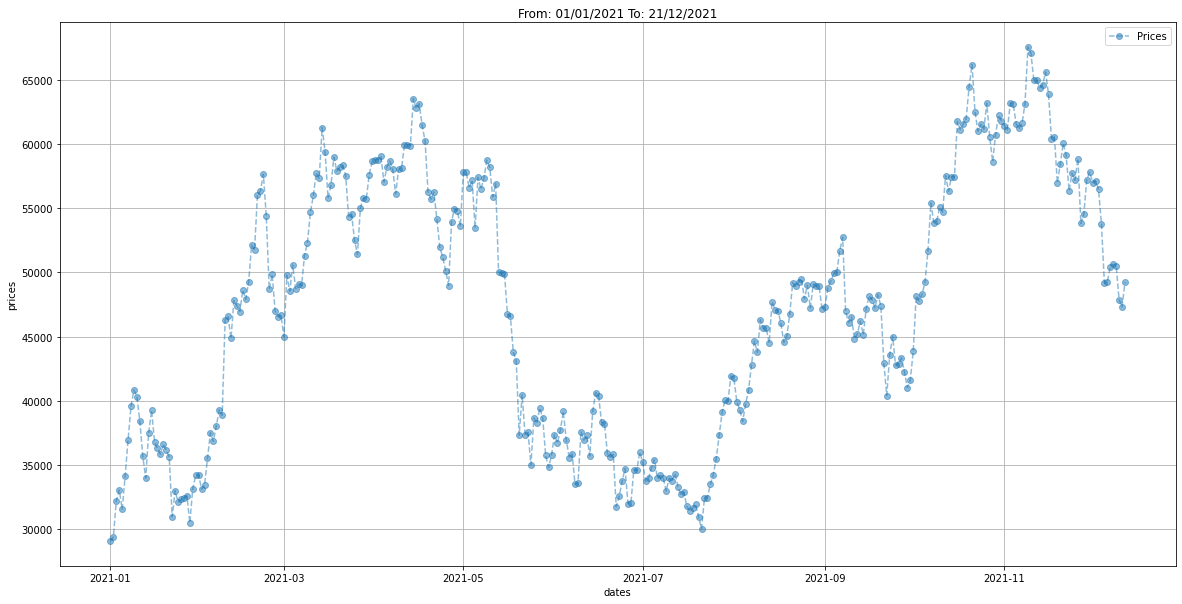

In [47]:
fig=plt.figure(figsize=(20, 10))
plt.plot(df['prices'], '--o', label = 'Prices', alpha = 0.5)
plt.title('From: ' + from_date + ' To: ' + to_date) 
plt.xlabel('dates')
plt.ylabel('prices')
plt.legend()
plt.grid(True)

In [48]:
# Esto hay que hacerlo pues es con la info de hoy predecir mañana
lag_days = 1
df["y"] = df["prices"].shift(-1 * lag_days)
df.tail(5)

,prices,total_volumes,y
dates,,,
2021-12-08,50647.663406,3.008331e+10,50530.458065
2021-12-09,50530.458065,2.659016e+10,47885.871989
2021-12-10,47885.871989,2.726936e+10,47303.564152
2021-12-11,47303.564152,2.961126e+10,49242.302324
2021-12-12,49242.302324,2.461913e+10,NaN


#### Se calculan indicadores para cada día

In [49]:
#https://towardsdatascience.com/building-a-comprehensive-set-of-technical-indicators-in-python-for-quantitative-trading-8d98751b5fb
# MovingAverage
values_ma = [5,10,15,30]

for i in values_ma:
    df["ma_close_" + str(i)] = df["prices"].rolling(window=i).mean()

# ExponentialMovingWindow
values_ema = [5,10,15,30]

for i in values_ema:
    df["ema_" + str(i)] = df["prices"].ewm(span = i, adjust = False).mean()
    
# RSI https://stackoverflow.com/questions/20526414/relative-strength-index-in-python-pandas
values_rsi = [7,10,14,21]
close = df['prices']

# Get the difference in price from previous step
delta = close.diff()

# Make the positive gains (up) and negative gains (down) Series
up, down = delta.copy(), delta.copy()
up[up < 0] = 0
down[down > 0] = 0

for i in values_rsi:
    # Calculate the EWMA
    #roll_up1 = up.ewm(span=i).mean()
    #roll_down1 = down.abs().ewm(span=i).mean()

    ## Calculate the RSI based on EWMA
    #RS1 = roll_up1 / roll_down1
    #RSI1 = 100.0 - (100.0 / (1.0 + RS1))

    # Calculate the SMA
    roll_up2 = up.rolling(i).mean()
    roll_down2 = down.abs().rolling(i).mean()

    # Calculate the RSI based on SMA
    RS2 = roll_up2 / roll_down2
    RSI2 = 100.0 - (100.0 / (1.0 + RS2))
    
    #df["rsi_ewma_" + str(i)] = RSI1.values
    df["rsi_sma_" + str(i)]  = RSI2.values
    
# BollingerBand
values_bollinger = [5,10,20]
for i in values_bollinger:
    df['bollinger_upper_' + str(i)] = df['prices'].rolling(window=i).mean() + (df['prices'].rolling(window=i).std()  * 2)
    df['bollinger_lower_' + str(i)] = df['prices'].rolling(window=i).mean() - (df['prices'].rolling(window=i).std()  * 2)

In [50]:
df.sample()

,prices,total_volumes,y,ma_close_5,ma_close_10,ma_close_15,ma_close_30,ema_5,ema_10,ema_15,ema_30,rsi_sma_7,rsi_sma_10,rsi_sma_14,rsi_sma_21,bollinger_upper_5,bollinger_lower_5,bollinger_upper_10,bollinger_lower_10,bollinger_upper_20,bollinger_lower_20
dates,,,,,,,,,,,,,,,,,,,,,
2021-10-14,57487.98588,4.121695e+10,57452.431785,56246.572426,54548.262789,51678.148755,48177.710037,56178.719207,54251.943977,52640.414861,50025.369595,62.315809,79.601989,84.488687,73.043216,58877.019324,53616.125529,59671.682862,49424.842715,61214.261096,37523.323585


In [51]:
minus = 20 # Es el lag del pasado cuanto pillamos

In [52]:
all_columns = list(df.columns)
keep_columns = [item for item in all_columns if item not in "y"]
print(keep_columns)

['prices', 'total_volumes', 'ma_close_5', 'ma_close_10', 'ma_close_15', 'ma_close_30', 'ema_5', 'ema_10', 'ema_15', 'ema_30', 'rsi_sma_7', 'rsi_sma_10', 'rsi_sma_14', 'rsi_sma_21', 'bollinger_upper_5', 'bollinger_lower_5', 'bollinger_upper_10', 'bollinger_lower_10', 'bollinger_upper_20', 'bollinger_lower_20']


In [53]:
list_shift = list(range(1, minus))

for i in list_shift:
    for j in keep_columns:
        df[str(j) + "minus" + str(i)] = df[str(j)].shift(i)

In [54]:
# Get feature from dates
# df['year'] = df.index.year
#df['month'] = df.index.month
#df['day'] = df.index.day.astype(str)
#df['weekday'] = df.index.dayofweek.astype(str)
#df['dayofyear'] = df.index.dayofyear
#df['is_month_start'] = (df.index.is_month_start).astype(int)
#df['is_month_end'] = (df.index.is_month_end).astype(int)

In [55]:
print("Shape: " + str(df.shape))
df.dropna(inplace = True)
print("Shape: " + str(df.shape))

Shape: (346, 401)
Shape: (297, 401)


In [56]:
df.tail(5)

,prices,total_volumes,y,ma_close_5,ma_close_10,ma_close_15,ma_close_30,ema_5,ema_10,ema_15,ema_30,rsi_sma_7,rsi_sma_10,rsi_sma_14,rsi_sma_21,bollinger_upper_5,bollinger_lower_5,bollinger_upper_10,bollinger_lower_10,bollinger_upper_20,bollinger_lower_20,pricesminus1,total_volumesminus1,ma_close_5minus1,ma_close_10minus1,ma_close_15minus1,ma_close_30minus1,ema_5minus1,ema_10minus1,ema_15minus1,ema_30minus1,rsi_sma_7minus1,rsi_sma_10minus1,rsi_sma_14minus1,rsi_sma_21minus1,bollinger_upper_5minus1,bollinger_lower_5minus1,bollinger_upper_10minus1,bollinger_lower_10minus1,bollinger_upper_20minus1,bollinger_lower_20minus1,pricesminus2,total_volumesminus2,ma_close_5minus2,ma_close_10minus2,ma_close_15minus2,ma_close_30minus2,ema_5minus2,ema_10minus2,ema_15minus2,ema_30minus2,rsi_sma_7minus2,rsi_sma_10minus2,rsi_sma_14minus2,rsi_sma_21minus2,bollinger_upper_5minus2,bollinger_lower_5minus2,bollinger_upper_10minus2,bollinger_lower_10minus2,bollinger_upper_20minus2,bollinger_lower_20minus2,pricesminus3,total_volumesminus3,ma_close_5minus3,ma_close_10minus3,ma_close_15minus3,ma_close_30minus3,ema_5minus3,ema_10minus3,ema_15minus3,ema_30minus3,rsi_sma_7minus3,rsi_sma_10minus3,rsi_sma_14minus3,rsi_sma_21minus3,bollinger_upper_5minus3,bollinger_lower_5minus3,bollinger_upper_10minus3,bollinger_lower_10minus3,bollinger_upper_20minus3,bollinger_lower_20minus3,pricesminus4,total_volumesminus4,ma_close_5minus4,ma_close_10minus4,ma_close_15minus4,ma_close_30minus4,ema_5minus4,ema_10minus4,ema_15minus4,ema_30minus4,rsi_sma_7minus4,rsi_sma_10minus4,rsi_sma_14minus4,rsi_sma_21minus4,bollinger_upper_5minus4,bollinger_lower_5minus4,bollinger_upper_10minus4,bollinger_lower_10minus4,bollinger_upper_20minus4,bollinger_lower_20minus4,pricesminus5,total_volumesminus5,ma_close_5minus5,ma_close_10minus5,ma_close_15minus5,ma_close_30minus5,ema_5minus5,ema_10minus5,ema_15minus5,ema_30minus5,rsi_sma_7minus5,rsi_sma_10minus5,rsi_sma_14minus5,rsi_sma_21minus5,bollinger_upper_5minus5,bollinger_lower_5minus5,bollinger_upper_10minus5,bollinger_lower_10minus5,bollinger_upper_20minus5,bollinger_lower_20minus5,pricesminus6,total_volumesminus6,ma_close_5minus6,ma_close_10minus6,ma_close_15minus6,ma_close_30minus6,ema_5minus6,ema_10minus6,ema_15minus6,ema_30minus6,rsi_sma_7minus6,rsi_sma_10minus6,rsi_sma_14minus6,rsi_sma_21minus6,bollinger_upper_5minus6,bollinger_lower_5minus6,bollinger_upper_10minus6,bollinger_lower_10minus6,bollinger_upper_20minus6,bollinger_lower_20minus6,pricesminus7,total_volumesminus7,ma_close_5minus7,ma_close_10minus7,ma_close_15minus7,ma_close_30minus7,ema_5minus7,ema_10minus7,ema_15minus7,ema_30minus7,rsi_sma_7minus7,rsi_sma_10minus7,rsi_sma_14minus7,rsi_sma_21minus7,bollinger_upper_5minus7,bollinger_lower_5minus7,bollinger_upper_10minus7,bollinger_lower_10minus7,bollinger_upper_20minus7,bollinger_lower_20minus7,pricesminus8,total_volumesminus8,ma_close_5minus8,ma_close_10minus8,ma_close_15minus8,ma_close_30minus8,ema_5minus8,ema_10minus8,ema_15minus8,ema_30minus8,rsi_sma_7minus8,rsi_sma_10minus8,rsi_sma_14minus8,rsi_sma_21minus8,bollinger_upper_5minus8,bollinger_lower_5minus8,bollinger_upper_10minus8,bollinger_lower_10minus8,bollinger_upper_20minus8,bollinger_lower_20minus8,pricesminus9,total_volumesminus9,ma_close_5minus9,ma_close_10minus9,ma_close_15minus9,ma_close_30minus9,ema_5minus9,ema_10minus9,ema_15minus9,ema_30minus9,rsi_sma_7minus9,rsi_sma_10minus9,rsi_sma_14minus9,rsi_sma_21minus9,bollinger_upper_5minus9,bollinger_lower_5minus9,bollinger_upper_10minus9,bollinger_lower_10minus9,bollinger_upper_20minus9,bollinger_lower_20minus9,pricesminus10,total_volumesminus10,ma_close_5minus10,ma_close_10minus10,ma_close_15minus10,ma_close_30minus10,ema_5minus10,ema_10minus10,ema_15minus10,ema_30minus10,rsi_sma_7minus10,rsi_sma_10minus10,rsi_sma_14minus10,rsi_sma_21minus10,bollinger_upper_5minus10,bollinger_lower_5minus10,bollinger_upper_10minus10,bollinger_lower_10minus10,bollinger_upper_20minus10,bollinger_lower_20minus10,pricesminus11,total_volumes

In [57]:
df["y"] = 100*( (df["y"] - df["prices"])/df["prices"])   
df.tail()

,prices,total_volumes,y,ma_close_5,ma_close_10,ma_close_15,ma_close_30,ema_5,ema_10,ema_15,ema_30,rsi_sma_7,rsi_sma_10,rsi_sma_14,rsi_sma_21,bollinger_upper_5,bollinger_lower_5,bollinger_upper_10,bollinger_lower_10,bollinger_upper_20,bollinger_lower_20,pricesminus1,total_volumesminus1,ma_close_5minus1,ma_close_10minus1,ma_close_15minus1,ma_close_30minus1,ema_5minus1,ema_10minus1,ema_15minus1,ema_30minus1,rsi_sma_7minus1,rsi_sma_10minus1,rsi_sma_14minus1,rsi_sma_21minus1,bollinger_upper_5minus1,bollinger_lower_5minus1,bollinger_upper_10minus1,bollinger_lower_10minus1,bollinger_upper_20minus1,bollinger_lower_20minus1,pricesminus2,total_volumesminus2,ma_close_5minus2,ma_close_10minus2,ma_close_15minus2,ma_close_30minus2,ema_5minus2,ema_10minus2,ema_15minus2,ema_30minus2,rsi_sma_7minus2,rsi_sma_10minus2,rsi_sma_14minus2,rsi_sma_21minus2,bollinger_upper_5minus2,bollinger_lower_5minus2,bollinger_upper_10minus2,bollinger_lower_10minus2,bollinger_upper_20minus2,bollinger_lower_20minus2,pricesminus3,total_volumesminus3,ma_close_5minus3,ma_close_10minus3,ma_close_15minus3,ma_close_30minus3,ema_5minus3,ema_10minus3,ema_15minus3,ema_30minus3,rsi_sma_7minus3,rsi_sma_10minus3,rsi_sma_14minus3,rsi_sma_21minus3,bollinger_upper_5minus3,bollinger_lower_5minus3,bollinger_upper_10minus3,bollinger_lower_10minus3,bollinger_upper_20minus3,bollinger_lower_20minus3,pricesminus4,total_volumesminus4,ma_close_5minus4,ma_close_10minus4,ma_close_15minus4,ma_close_30minus4,ema_5minus4,ema_10minus4,ema_15minus4,ema_30minus4,rsi_sma_7minus4,rsi_sma_10minus4,rsi_sma_14minus4,rsi_sma_21minus4,bollinger_upper_5minus4,bollinger_lower_5minus4,bollinger_upper_10minus4,bollinger_lower_10minus4,bollinger_upper_20minus4,bollinger_lower_20minus4,pricesminus5,total_volumesminus5,ma_close_5minus5,ma_close_10minus5,ma_close_15minus5,ma_close_30minus5,ema_5minus5,ema_10minus5,ema_15minus5,ema_30minus5,rsi_sma_7minus5,rsi_sma_10minus5,rsi_sma_14minus5,rsi_sma_21minus5,bollinger_upper_5minus5,bollinger_lower_5minus5,bollinger_upper_10minus5,bollinger_lower_10minus5,bollinger_upper_20minus5,bollinger_lower_20minus5,pricesminus6,total_volumesminus6,ma_close_5minus6,ma_close_10minus6,ma_close_15minus6,ma_close_30minus6,ema_5minus6,ema_10minus6,ema_15minus6,ema_30minus6,rsi_sma_7minus6,rsi_sma_10minus6,rsi_sma_14minus6,rsi_sma_21minus6,bollinger_upper_5minus6,bollinger_lower_5minus6,bollinger_upper_10minus6,bollinger_lower_10minus6,bollinger_upper_20minus6,bollinger_lower_20minus6,pricesminus7,total_volumesminus7,ma_close_5minus7,ma_close_10minus7,ma_close_15minus7,ma_close_30minus7,ema_5minus7,ema_10minus7,ema_15minus7,ema_30minus7,rsi_sma_7minus7,rsi_sma_10minus7,rsi_sma_14minus7,rsi_sma_21minus7,bollinger_upper_5minus7,bollinger_lower_5minus7,bollinger_upper_10minus7,bollinger_lower_10minus7,bollinger_upper_20minus7,bollinger_lower_20minus7,pricesminus8,total_volumesminus8,ma_close_5minus8,ma_close_10minus8,ma_close_15minus8,ma_close_30minus8,ema_5minus8,ema_10minus8,ema_15minus8,ema_30minus8,rsi_sma_7minus8,rsi_sma_10minus8,rsi_sma_14minus8,rsi_sma_21minus8,bollinger_upper_5minus8,bollinger_lower_5minus8,bollinger_upper_10minus8,bollinger_lower_10minus8,bollinger_upper_20minus8,bollinger_lower_20minus8,pricesminus9,total_volumesminus9,ma_close_5minus9,ma_close_10minus9,ma_close_15minus9,ma_close_30minus9,ema_5minus9,ema_10minus9,ema_15minus9,ema_30minus9,rsi_sma_7minus9,rsi_sma_10minus9,rsi_sma_14minus9,rsi_sma_21minus9,bollinger_upper_5minus9,bollinger_lower_5minus9,bollinger_upper_10minus9,bollinger_lower_10minus9,bollinger_upper_20minus9,bollinger_lower_20minus9,pricesminus10,total_volumesminus10,ma_close_5minus10,ma_close_10minus10,ma_close_15minus10,ma_close_30minus10,ema_5minus10,ema_10minus10,ema_15minus10,ema_30minus10,rsi_sma_7minus10,rsi_sma_10minus10,rsi_sma_14minus10,rsi_sma_21minus10,bollinger_upper_5minus10,bollinger_lower_5minus10,bollinger_upper_10minus10,bollinger_lower_10minus10,bollinger_upper_20minus10,bollinger_lower_20minus10,pricesminus11,total_volumes

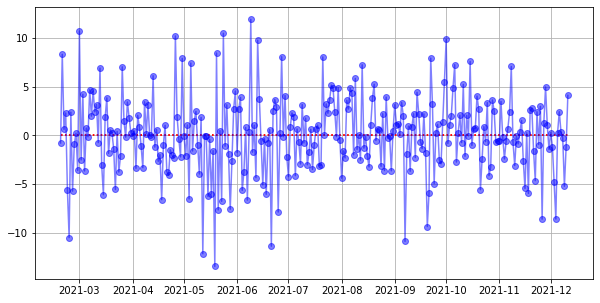

In [58]:
cota_max = 0
cota_min = 0
fig=plt.figure(figsize=(10, 5))
plt.plot(df['y'], '-ob', label = 'Delta', alpha = 0.5)
plt.hlines(cota_max, df.index.min(), df.index.max(), color='r', ls=':')
plt.hlines(cota_min, df.index.min(), df.index.max(), color='r', ls=':')
plt.grid(True)

In [59]:
# 0: Sube
# 1: Baja

df['y'] = [0 if x > cota_max else 1 for x in df['y']]

In [60]:
df.tail(2)

,prices,total_volumes,y,ma_close_5,ma_close_10,ma_close_15,ma_close_30,ema_5,ema_10,ema_15,ema_30,rsi_sma_7,rsi_sma_10,rsi_sma_14,rsi_sma_21,bollinger_upper_5,bollinger_lower_5,bollinger_upper_10,bollinger_lower_10,bollinger_upper_20,bollinger_lower_20,pricesminus1,total_volumesminus1,ma_close_5minus1,ma_close_10minus1,ma_close_15minus1,ma_close_30minus1,ema_5minus1,ema_10minus1,ema_15minus1,ema_30minus1,rsi_sma_7minus1,rsi_sma_10minus1,rsi_sma_14minus1,rsi_sma_21minus1,bollinger_upper_5minus1,bollinger_lower_5minus1,bollinger_upper_10minus1,bollinger_lower_10minus1,bollinger_upper_20minus1,bollinger_lower_20minus1,pricesminus2,total_volumesminus2,ma_close_5minus2,ma_close_10minus2,ma_close_15minus2,ma_close_30minus2,ema_5minus2,ema_10minus2,ema_15minus2,ema_30minus2,rsi_sma_7minus2,rsi_sma_10minus2,rsi_sma_14minus2,rsi_sma_21minus2,bollinger_upper_5minus2,bollinger_lower_5minus2,bollinger_upper_10minus2,bollinger_lower_10minus2,bollinger_upper_20minus2,bollinger_lower_20minus2,pricesminus3,total_volumesminus3,ma_close_5minus3,ma_close_10minus3,ma_close_15minus3,ma_close_30minus3,ema_5minus3,ema_10minus3,ema_15minus3,ema_30minus3,rsi_sma_7minus3,rsi_sma_10minus3,rsi_sma_14minus3,rsi_sma_21minus3,bollinger_upper_5minus3,bollinger_lower_5minus3,bollinger_upper_10minus3,bollinger_lower_10minus3,bollinger_upper_20minus3,bollinger_lower_20minus3,pricesminus4,total_volumesminus4,ma_close_5minus4,ma_close_10minus4,ma_close_15minus4,ma_close_30minus4,ema_5minus4,ema_10minus4,ema_15minus4,ema_30minus4,rsi_sma_7minus4,rsi_sma_10minus4,rsi_sma_14minus4,rsi_sma_21minus4,bollinger_upper_5minus4,bollinger_lower_5minus4,bollinger_upper_10minus4,bollinger_lower_10minus4,bollinger_upper_20minus4,bollinger_lower_20minus4,pricesminus5,total_volumesminus5,ma_close_5minus5,ma_close_10minus5,ma_close_15minus5,ma_close_30minus5,ema_5minus5,ema_10minus5,ema_15minus5,ema_30minus5,rsi_sma_7minus5,rsi_sma_10minus5,rsi_sma_14minus5,rsi_sma_21minus5,bollinger_upper_5minus5,bollinger_lower_5minus5,bollinger_upper_10minus5,bollinger_lower_10minus5,bollinger_upper_20minus5,bollinger_lower_20minus5,pricesminus6,total_volumesminus6,ma_close_5minus6,ma_close_10minus6,ma_close_15minus6,ma_close_30minus6,ema_5minus6,ema_10minus6,ema_15minus6,ema_30minus6,rsi_sma_7minus6,rsi_sma_10minus6,rsi_sma_14minus6,rsi_sma_21minus6,bollinger_upper_5minus6,bollinger_lower_5minus6,bollinger_upper_10minus6,bollinger_lower_10minus6,bollinger_upper_20minus6,bollinger_lower_20minus6,pricesminus7,total_volumesminus7,ma_close_5minus7,ma_close_10minus7,ma_close_15minus7,ma_close_30minus7,ema_5minus7,ema_10minus7,ema_15minus7,ema_30minus7,rsi_sma_7minus7,rsi_sma_10minus7,rsi_sma_14minus7,rsi_sma_21minus7,bollinger_upper_5minus7,bollinger_lower_5minus7,bollinger_upper_10minus7,bollinger_lower_10minus7,bollinger_upper_20minus7,bollinger_lower_20minus7,pricesminus8,total_volumesminus8,ma_close_5minus8,ma_close_10minus8,ma_close_15minus8,ma_close_30minus8,ema_5minus8,ema_10minus8,ema_15minus8,ema_30minus8,rsi_sma_7minus8,rsi_sma_10minus8,rsi_sma_14minus8,rsi_sma_21minus8,bollinger_upper_5minus8,bollinger_lower_5minus8,bollinger_upper_10minus8,bollinger_lower_10minus8,bollinger_upper_20minus8,bollinger_lower_20minus8,pricesminus9,total_volumesminus9,ma_close_5minus9,ma_close_10minus9,ma_close_15minus9,ma_close_30minus9,ema_5minus9,ema_10minus9,ema_15minus9,ema_30minus9,rsi_sma_7minus9,rsi_sma_10minus9,rsi_sma_14minus9,rsi_sma_21minus9,bollinger_upper_5minus9,bollinger_lower_5minus9,bollinger_upper_10minus9,bollinger_lower_10minus9,bollinger_upper_20minus9,bollinger_lower_20minus9,pricesminus10,total_volumesminus10,ma_close_5minus10,ma_close_10minus10,ma_close_15minus10,ma_close_30minus10,ema_5minus10,ema_10minus10,ema_15minus10,ema_30minus10,rsi_sma_7minus10,rsi_sma_10minus10,rsi_sma_14minus10,rsi_sma_21minus10,bollinger_upper_5minus10,bollinger_lower_5minus10,bollinger_upper_10minus10,bollinger_lower_10minus10,bollinger_upper_20minus10,bollinger_lower_20minus10,pricesminus11,total_volumes

In [61]:
df.dtypes.value_counts()

float64    400
int64        1
dtype: int64

In [62]:
# Importing module and initializing setup
# https://pycaret.readthedocs.io/en/latest/api/classification.html
from pycaret.classification import *

def pipeline(df):
    modelo = setup(data = df,
                   target = 'y', feature_interaction = False,
                   #remove_multicollinearity = True, multicollinearity_threshold = 0.8,
                   normalize = True, normalize_method = "zscore",
                   silent = True, verbose=False);

In [63]:
print("Dimensiones :" , df.shape)

Dimensiones : (297, 401)


In [64]:
past_t = 250 # Es hiperparametro del modelo

In [68]:
y_real = pd.DataFrame(list(df["y"].iloc[past_t:len(df["y"])]), columns = ["y_real"], index = df["y"].iloc[past_t:len(df["y"])].index)
y_pred = pd.DataFrame([999] * (len(df["y"])-past_t), columns = ["y_pred"], index = df["y"].iloc[past_t:len(df["y"])].index, dtype = 'int')
y_score = pd.DataFrame([999] * (len(df["y"])-past_t), columns = ["y_score"], index = df["y"].iloc[past_t:len(df["y"])].index, dtype = 'int')

comparacion = pd.concat([y_real, y_pred, y_score], axis =1).copy()
comparacion.dtypes

y_real     int64
y_pred     int32
y_score    int32
dtype: object

In [69]:
tope = len(df)-past_t

# Classification: Accuracy, AUC, Recall, Precision, F1, Kappa, MCC
metrica = "AUC"

print("Tope: " + str(tope))

Tope: 47


In [70]:
for i in range(0, tope):
    # Train
    train = df.iloc[i:i+past_t]
    
    # Test
    test = df.iloc[i+past_t:i+past_t+1]
    
    # Crear pipeline
    pipeline(train)
    
    # Modelo
    modelo = compare_models(sort = metrica, exclude = ["knn"], verbose=False)
    
    modelo = tune_model(modelo, search_algorithm = "tpe", search_library = "optuna", optimize = metrica, n_iter = 10,
                        tuner_verbose = False, choose_better = True, verbose = False );
    
    final_modelo = finalize_model(modelo)
    prediccion = predict_model(final_modelo, data = test)
    
    comparacion.at[ df.iloc[past_t:len(df["y"])].index[i], "y_pred" ]  = prediccion["Label"][0]
    comparacion.at[ df.iloc[past_t:len(df["y"])].index[i], "y_real" ]  = prediccion["y"][0]
    comparacion.at[ df.iloc[past_t:len(df["y"])].index[i], "y_score" ]  = prediccion["Score"][0]
    
    print("Iteration: " + str(i+1) + "/" + str(tope) + " | Date " + str(test.index[0]) + " | RealValue " + str(test.y[0]) + " | Prediccion " + str(prediccion.Label[0]) \
          + " | Score " + str(prediccion.Score[0]), end = "\r")

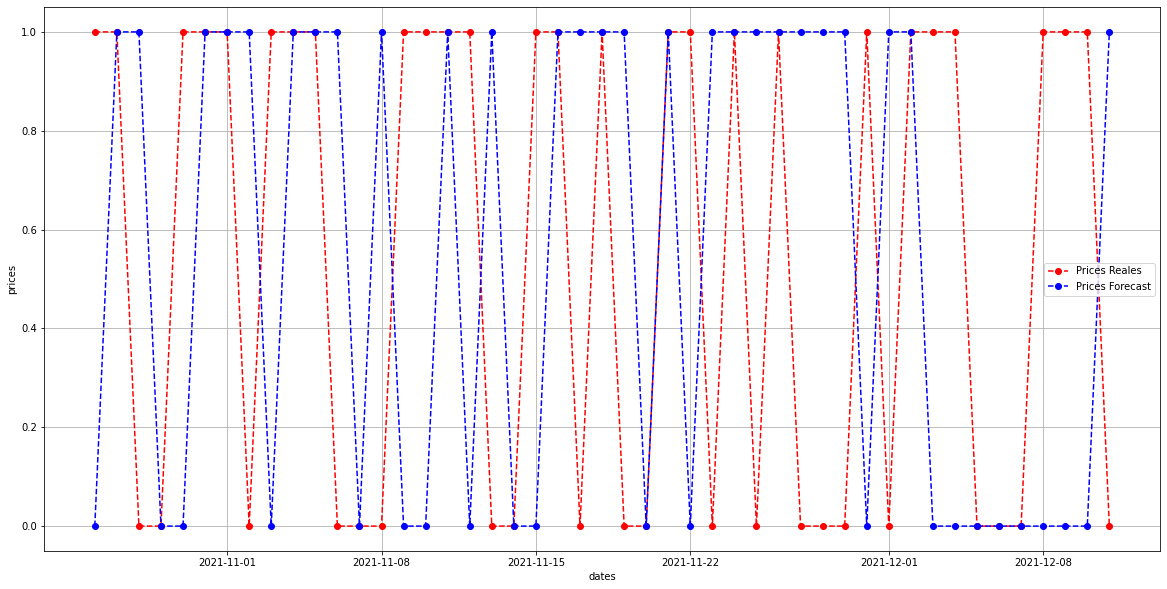

In [71]:
fig=plt.figure(figsize=(20, 10))
plt.plot(comparacion['y_real'], '--bo', label = 'Prices Reales', color = "r")
plt.plot(comparacion["y_pred"], '--bo', label = 'Prices Forecast', color = "b")
plt.xlabel('dates')
plt.ylabel('prices')
plt.legend()
plt.grid(True)
plt.savefig('imagen.png', dpi = 200)
plt.show()

In [74]:
comparacion[comparacion["y_pred"] != comparacion["y_real"]]

,y_real,y_pred,y_score
dates,,,
2021-10-26,1,0,0
2021-10-28,0,1,0
2021-10-30,1,0,0
2021-11-02,0,1,1
2021-11-03,1,0,1
2021-11-06,0,1,1
2021-11-08,0,1,1
2021-11-09,1,0,0
2021-11-10,1,0,0


In [72]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(comparacion["y_real"], comparacion["y_pred"])

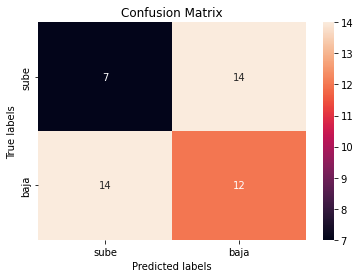

In [73]:
import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
lista_tags = ["sube","baja"]
ax.xaxis.set_ticklabels(lista_tags); ax.yaxis.set_ticklabels(lista_tags);

### Telegram

In [36]:
import telepot

bot_token = '1653124784:AAFpL0qlC_ybadcbFX6jKagauRFpiFpSf1E'
chatID = '-1001701018194'

bot = telepot.Bot(bot_token)

In [37]:
#ot.sendMessage(bot_chatID, "HALA")
bot.sendPhoto(chatID, photo=open('imagen.png', 'rb'))

{'message_id': 18,
 'from': {'id': 1653124784,
  'is_bot': True,
  'first_name': 'JARVIS',
  'username': 'JARVIS_Walkn_bot'},
 'chat': {'id': -1001701018194,
  'title': 'MoneyIsJustANumber',
  'type': 'supergroup'},
 'date': 1639264910,
 'photo': [{'file_id': 'AgACAgQAAx0EZWN6UgADEmG1Mo6nWvjhI4NaqDoHp9q3AAGOkAAC8bsxG8zgqVESWBCv1QOhfAEAAwIAA3MAAyME',
   'file_unique_id': 'AQAD8bsxG8zgqVF4',
   'file_size': 700,
   'width': 90,
   'height': 45},
  {'file_id': 'AgACAgQAAx0EZWN6UgADEmG1Mo6nWvjhI4NaqDoHp9q3AAGOkAAC8bsxG8zgqVESWBCv1QOhfAEAAwIAA20AAyME',
   'file_unique_id': 'AQAD8bsxG8zgqVFy',
   'file_size': 11807,
   'width': 320,
   'height': 160},
  {'file_id': 'AgACAgQAAx0EZWN6UgADEmG1Mo6nWvjhI4NaqDoHp9q3AAGOkAAC8bsxG8zgqVESWBCv1QOhfAEAAwIAA3gAAyME',
   'file_unique_id': 'AQAD8bsxG8zgqVF9',
   'file_size': 56989,
   'width': 800,
   'height': 400},
  {'file_id': 'AgACAgQAAx0EZWN6UgADEmG1Mo6nWvjhI4NaqDoHp9q3AAGOkAAC8bsxG8zgqVESWBCv1QOhfAEAAwIAA3kAAyME',
   'file_unique_id': 'AQAD8bsxG8zg